In [1]:
import torch
from torch import nn, optim
import zipfile
import os
import random
import numpy as np
import shutil
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

In [2]:
data_path = 'drive/MyDrive/ИИ/Test.zip'

with zipfile.ZipFile(data_path, 'r') as zip_ref:
    zip_ref.extractall()

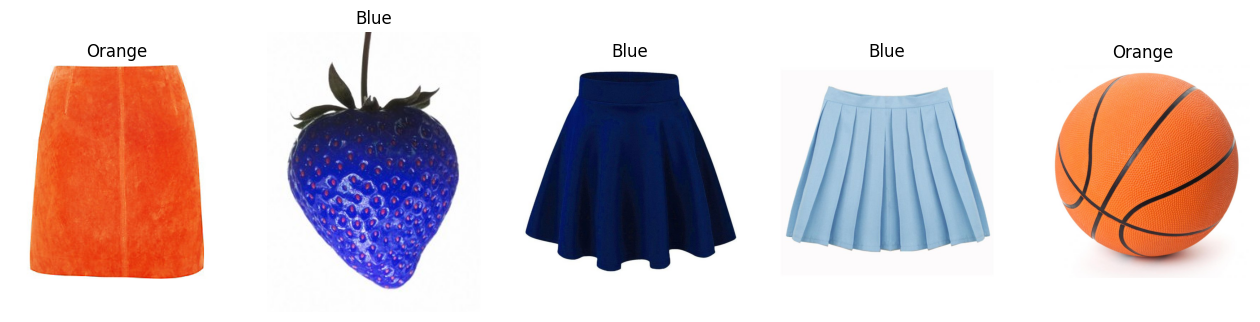

In [4]:
image_path = Path('Test')
image_path_list = list(image_path.glob('*/*.jpg'))

size_image = 5

plt.figure(figsize=(16, 8))

for i in range(size_image):
  plt.subplot(1, size_image,  i + 1)
  random_image = random.choice(image_path_list)
  image_class = random_image.parent.stem
  img = Image.open(random_image)
  plt.imshow(img)
  plt.title(image_class)
  plt.axis('off')

plt.show()

In [145]:
# to del
# shutil.rmtree(image_path)

In [5]:
os.listdir(image_path)

['Orange', 'Blue']

In [6]:
train_dir = image_path / 'train'
val_dir = image_path / 'validation'
test_dir = image_path / 'test'
class_names = os.listdir(image_path)

train_dir.mkdir(exist_ok=True)
val_dir.mkdir(exist_ok=True)
test_dir.mkdir(exist_ok=True)

for name in class_names:
  (train_dir / name).mkdir(exist_ok=True)
  (val_dir / name).mkdir(exist_ok=True)
  (test_dir / name).mkdir(exist_ok=True)

  class_list = os.listdir(image_path / name)

  total_images = len(class_list)
  train_size = int(0.8 * total_images)
  val_size = test_size = int(0.1 * total_images)

  train_images = class_list[:train_size]
  val_images = class_list[train_size:train_size + val_size]
  test_images = class_list[train_size + val_size:train_size + val_size + test_size]

  # можно сделать и сopy
  for img in train_images:
    shutil.move(str(image_path / name / img), str(train_dir / name / img))
  for img in val_images:
    shutil.move(str(image_path / name / img), str(val_dir / name / img))
  for img in test_images:
    shutil.move(str(image_path / name / img), str(test_dir / name / img))

In [7]:
for dir_path, dir_names, filenames in os.walk(image_path):
  print(f'В папке {dir_path}, {len(dir_names)} директорий и {len(filenames)} изображений')

В папке Test, 5 директорий и 0 изображений
В папке Test/validation, 2 директорий и 0 изображений
В папке Test/validation/Orange, 0 директорий и 1 изображений
В папке Test/validation/Blue, 0 директорий и 1 изображений
В папке Test/Orange, 0 директорий и 0 изображений
В папке Test/Blue, 0 директорий и 0 изображений
В папке Test/train, 2 директорий и 0 изображений
В папке Test/train/Orange, 0 директорий и 8 изображений
В папке Test/train/Blue, 0 директорий и 8 изображений
В папке Test/test, 2 директорий и 0 изображений
В папке Test/test/Orange, 0 директорий и 1 изображений
В папке Test/test/Blue, 0 директорий и 1 изображений


In [8]:
train_images = list(train_dir.glob('*/*.jpg'))
val_images = list(train_dir.glob('*/*.jpg'))
test_images = list(train_dir.glob('*/*.jpg'))

In [9]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [98]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

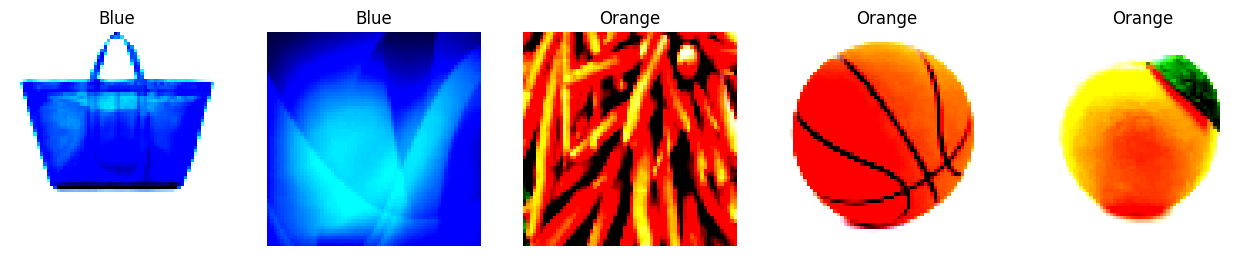

In [107]:
plt.figure(figsize=(16, 8))

for i in range(size_image):
    plt.subplot(1, size_image, i + 1)
    random_image = random.choice(train_images)
    image_class = random_image.parent.stem
    img = Image.open(random_image)
    transformed_image = data_transform(img).permute(1, 2, 0)
    plt.imshow(transformed_image)
    plt.title(image_class)
    plt.axis('off')

plt.show()

In [101]:
train_data = datasets.ImageFolder(
    root=train_dir,
    transform=data_transform,
    target_transform=None
)

val_data = datasets.ImageFolder(
    root=val_dir,
    transform=data_transform,
    target_transform=None
)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=data_transform,
)

In [102]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1,
                              num_workers=1,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_data,
                              batch_size=1,
                              num_workers=1,
                              shuffle=False)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=1,
                              num_workers=1,
                              shuffle=False)

In [103]:
print(f'Number of training batches per epoch: {len(train_dataloader)}')
print(f'Number of validation batches per epoch: {len(val_dataloader)}')
print(f'Number of test batches per epoch: {len(test_dataloader)}')

Number of training batches per epoch: 16
Number of validation batches per epoch: 2
Number of test batches per epoch: 2


In [191]:
class Model(nn.Module):
  def __init__(self, input_shape, output_shape):
    super().__init__()

    self.logreg = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=output_shape)
    )

  def forward(self, x):
    x = self.logreg(x)
    return x

model = Model(input_shape=3 * 64 * 64, output_shape=1)
model

Model(
  (logreg): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12288, out_features=1, bias=True)
  )
)

In [192]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1e-4)

In [193]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    res = 0
    for batch_features, batch_labels in train_dataloader:
        y_logits = model(batch_features).squeeze()

        loss = criterion(y_logits, batch_labels.squeeze().float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred = torch.round(torch.sigmoid(y_logits))

    model.eval()
    val_loss = 0
    correct = 0
    with torch.inference_mode():
        for val_features, val_labels in val_dataloader:
            y_logits = model(val_features).squeeze()

            validation_loss = criterion(y_logits, val_labels.squeeze().float())
            val_loss += validation_loss.item()

            val_pred = torch.round(torch.sigmoid(y_logits))
            print('val pred', val_pred.item(),'val real', val_labels.item(), end=' | ')
            correct += (val_pred == val_labels).sum().item()

    val_loss /= len(val_dataloader)
    val_accuracy = correct / len(val_dataloader.dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

val pred 1.0 val real 0 | val pred 0.0 val real 1 | Epoch 1/5, Loss: 0.8803322911262512, Validation Loss: 0.8889579176902771, Validation Accuracy: 0.0
val pred 0.0 val real 0 | val pred 1.0 val real 1 | Epoch 2/5, Loss: 0.7364597320556641, Validation Loss: 0.4164882302284241, Validation Accuracy: 1.0
val pred 0.0 val real 0 | val pred 1.0 val real 1 | Epoch 3/5, Loss: 0.2196625918149948, Validation Loss: 0.24541925638914108, Validation Accuracy: 1.0
val pred 0.0 val real 0 | val pred 1.0 val real 1 | Epoch 4/5, Loss: 0.3163750171661377, Validation Loss: 0.15771488100290298, Validation Accuracy: 1.0
val pred 0.0 val real 0 | val pred 1.0 val real 1 | Epoch 5/5, Loss: 0.08778335899114609, Validation Loss: 0.11249201744794846, Validation Accuracy: 1.0


In [194]:
model.eval()
test_loss = 0
correct = 0

with torch.no_grad():
    for test_features, test_labels in test_dataloader:
        y_logits = model(test_features).squeeze()

        loss = criterion(y_logits, test_labels.squeeze().float())
        test_loss += loss.item()
        y_pred = torch.round(torch.sigmoid(y_logits))
        correct += torch.sum(y_pred == test_labels.data)

test_loss /= len(test_dataloader)
test_accuracy = correct.double() / len(test_dataloader.dataset)

print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Test Loss: 0.34497758746147156, Test Accuracy: 1.0


In [205]:
train_val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [206]:
train_data = datasets.ImageFolder(
    root=train_dir,
    transform=train_val_transforms,
    target_transform=None
)

val_data = datasets.ImageFolder(
    root=val_dir,
    transform=train_val_transforms,
    target_transform=None
)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=test_transforms,
)

In [207]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=2,
                              num_workers=1,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_data,
                              batch_size=2,
                              num_workers=1,
                              shuffle=False)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=2,
                              num_workers=1,
                              shuffle=False)

In [218]:
model_2 = Model(input_shape=3 * 224 * 224, output_shape=1)

In [219]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.1e-4)

In [220]:
num_epochs = 5

for epoch in range(num_epochs):
    model_2.train()
    res = 0
    for batch_features, batch_labels in train_dataloader:
        y_logits = model_2(batch_features).squeeze()

        loss = criterion(y_logits, batch_labels.squeeze().float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred = torch.round(torch.sigmoid(y_logits))

    model_2.eval()
    val_loss = 0
    correct = 0
    with torch.inference_mode():
        for val_features, val_labels in val_dataloader:
            y_logits = model_2(val_features).squeeze()

            validation_loss = criterion(y_logits, val_labels.squeeze().float())
            val_loss += validation_loss.item()

            val_pred = torch.round(torch.sigmoid(y_logits))
            correct += (val_pred == val_labels).sum().item()

    val_loss /= len(val_dataloader)
    val_accuracy = correct / len(val_dataloader.dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

Epoch 1/5, Loss: 0.16005612909793854, Validation Loss: 0.38851502537727356, Validation Accuracy: 0.5
Epoch 2/5, Loss: 0.0026099681854248047, Validation Loss: 0.00016257580136880279, Validation Accuracy: 1.0
Epoch 3/5, Loss: 0.0018615295412018895, Validation Loss: 0.003293928224593401, Validation Accuracy: 1.0
Epoch 4/5, Loss: 0.01840949058532715, Validation Loss: 0.8017618060112, Validation Accuracy: 0.5
Epoch 5/5, Loss: 6.764961199223762e-06, Validation Loss: 0.01263293344527483, Validation Accuracy: 1.0


In [221]:
model_2.eval()
test_loss = 0
correct = 0

with torch.no_grad():
    for test_features, test_labels in test_dataloader:
        y_logits = model_2(test_features).squeeze()

        loss = criterion(y_logits, test_labels.squeeze().float())
        test_loss += loss.item()
        y_pred = torch.round(torch.sigmoid(y_logits))
        correct += torch.sum(y_pred == test_labels.data)

test_loss /= len(test_dataloader)
test_accuracy = correct.double() / len(test_dataloader.dataset)

print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Test Loss: 0.0007829591049812734, Test Accuracy: 1.0
